# Method 5 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

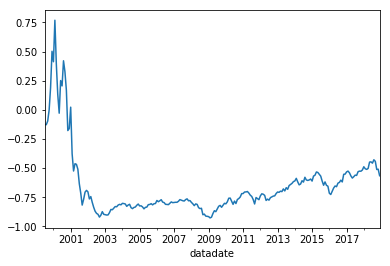

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.502635
2000-12-31   -0.441059
2001-12-31   -0.631997
2002-12-31   -0.664434
2003-12-31    0.788190
2004-12-31    0.035014
2005-12-31    0.022679
2006-12-31    0.038369
2007-12-31    0.088540
2008-12-31   -0.608895
2009-12-31    1.282427
2010-12-31    0.420587
2011-12-31   -0.184823
2012-12-31    0.231193
2013-12-31    0.360881
2014-12-31    0.058220
2015-12-31   -0.151324
2016-12-31    0.300233
2017-12-31    0.079020
2018-12-31   -0.101809
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     194.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.01e-72
Time:                        06:12:29   Log-Likelihood:                 348.58
No. Observations:                 234   AIC:                            -687.2
Df Residuals:                     229   BIC:                            -669.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.546      0.586      -0.005       0.009
mktrf          1.4009      0.103     13.621      0.000       1.198       1.604
me             0.4197      0.120      3.508      0.001       0.184       0.655
ia            -0.7485      0.182     -4.117      0.000      -1.107      -0.390
roe           -1.2608      0.156     -8.100      0.000      -1.567      -0.954
==============================================================================
Omnibus:                      128.907   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2236.413
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                      17.749   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     59.14
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.09e-34
Time:                        06:12:29   Log-Likelihood:                 348.58
No. Observations:                 234   AIC:                            -687.2
Df Residuals:                     229   BIC:                            -669.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.562      0.574      -0.005       0.009
mktrf          1.4009      0.210      6.661      0.000       0.989       1.813
me             0.4197      0.182      2.308      0.021       0.063       0.776
ia            -0.7485      0.254     -2.944      0.003      -1.247      -0.250
roe           -1.2608      0.245     -5.138      0.000      -1.742      -0.780
==============================================================================
Omnibus:                      128.907   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2236.413
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                      17.749   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     81.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.34e-43
Time:                        06:12:29   Log-Likelihood:                 348.58
No. Observations:                 234   AIC:                            -687.2
Df Residuals:                     229   BIC:                            -669.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.549      0.583      -0.005       0.009
mktrf          1.4009      0.215      6.511      0.000       0.979       1.823
me             0.4197      0.193      2.179      0.029       0.042       0.797
ia            -0.7485      0.243     -3.078      0.002      -1.225      -0.272
roe           -1.2608      0.264     -4.782      0.000      -1.778      -0.744
==============================================================================
Omnibus:                      128.907   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2236.413
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                      17.749   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     166.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.23e-74
Time:                        06:12:29   Log-Likelihood:                 355.34
No. Observations:                 234   AIC:                            -698.7
Df Residuals:                     228   BIC:                            -677.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.004      0.478      0.633      -0.006       0.009
mktrf          1.5153      0.100     15.102      0.000       1.318       1.713
smb            0.3843      0.132      2.903      0.004       0.123       0.645
hml           -0.2957      0.156     -1.894      0.059      -0.603       0.012
rmw           -1.3109      0.177     -7.427      0.000      -1.659      -0.963
cma           -0.1361      0.224     -0.607      0.545      -0.578       0.306
==============================================================================
Omnibus:                      123.053   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1346.130
Skew:                           1.781   Prob(JB):                    4.91e-293
Kurtosis:                      14.197   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     92.18
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.23e-53
Time:                        06:12:29   Log-Likelihood:                 355.34
No. Observations:                 234   AIC:                            -698.7
Df Residuals:                     228   BIC:                            -677.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.577      0.564      -0.004       0.008
mktrf          1.5153      0.128     11.838      0.000       1.264       1.766
smb            0.3843      0.128      3.013      0.003       0.134       0.634
hml           -0.2957      0.279     -1.061      0.289      -0.842       0.250
rmw           -1.3109      0.227     -5.782      0.000      -1.755      -0.867
cma           -0.1361      0.357     -0.381      0.703      -0.836       0.564
==============================================================================
Omnibus:                      123.053   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1346.130
Skew:                           1.781   Prob(JB):                    4.91e-293
Kurtosis:                      14.197   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     97.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.60e-54
Time:                        06:12:29   Log-Likelihood:                 355.34
No. Observations:                 234   AIC:                            -698.7
Df Residuals:                     228   BIC:                            -677.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.577      0.564      -0.004       0.008
mktrf          1.5153      0.124     12.266      0.000       1.273       1.757
smb            0.3843      0.126      3.056      0.002       0.138       0.631
hml           -0.2957      0.232     -1.275      0.202      -0.750       0.159
rmw           -1.3109      0.245     -5.348      0.000      -1.791      -0.830
cma           -0.1361      0.300     -0.454      0.650      -0.724       0.451
==============================================================================
Omnibus:                      123.053   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1346.130
Skew:                           1.781   Prob(JB):                    4.91e-293
Kurtosis:                      14.197   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     192.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.68e-72
Time:                        06:12:29   Log-Likelihood:                 347.52
No. Observations:                 234   AIC:                            -685.0
Df Residuals:                     229   BIC:                            -667.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.004     -0.791      0.430      -0.010       0.004
mktrf          1.6518      0.095     17.365      0.000       1.464       1.839
smb            0.9922      0.119      8.356      0.000       0.758       1.226
hml           -0.7333      0.118     -6.217      0.000      -0.966      -0.501
umd           -0.4395      0.077     -5.679      0.000      -0.592      -0.287
==============================================================================
Omnibus:                      103.783   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1026.642
Skew:                           1.448   Prob(JB):                    1.17e-223
Kurtosis:                      12.844   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     71.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.27e-39
Time:                        06:12:29   Log-Likelihood:                 347.52
No. Observations:                 234   AIC:                            -685.0
Df Residuals:                     229   BIC:                            -667.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.003     -0.902      0.367      -0.009       0.003
mktrf          1.6518      0.152     10.870      0.000       1.354       1.950
smb            0.9922      0.125      7.933      0.000       0.747       1.237
hml           -0.7333      0.201     -3.645      0.000      -1.128      -0.339
umd           -0.4395      0.124     -3.531      0.000      -0.684      -0.196
==============================================================================
Omnibus:                      103.783   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1026.642
Skew:                           1.448   Prob(JB):                    1.17e-223
Kurtosis:                      12.844   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     75.09
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-40
Time:                        06:12:29   Log-Likelihood:                 347.52
No. Observations:                 234   AIC:                            -685.0
Df Residuals:                     229   BIC:                            -667.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.003     -0.902      0.367      -0.009       0.003
mktrf          1.6518      0.156     10.598      0.000       1.346       1.957
smb            0.9922      0.108      9.214      0.000       0.781       1.203
hml           -0.7333      0.191     -3.843      0.000      -1.107      -0.359
umd           -0.4395      0.128     -3.433      0.001      -0.690      -0.189
==============================================================================
Omnibus:                      103.783   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1026.642
Skew:                           1.448   Prob(JB):                    1.17e-223
Kurtosis:                      12.844   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     93.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.92e-35
Time:                        06:12:29   Log-Likelihood:                 152.77
No. Observations:                 120   AIC:                            -295.5
Df Residuals:                     115   BIC:                            -281.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.007      0.590      0.557      -0.009       0.017
mktrf          1.2348      0.178      6.923      0.000       0.881       1.588
me             0.3253      0.176      1.846      0.067      -0.024       0.674
ia            -0.9532      0.276     -3.456      0.001      -1.500      -0.407
roe           -1.4501      0.244     -5.939      0.000      -1.934      -0.966
==============================================================================
Omnibus:                       58.445   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.215
Skew:                           1.416   Prob(JB):                     2.31e-94
Kurtosis:                      11.845   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     49.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.53e-24
Time:                        06:12:29   Log-Likelihood:                 152.77
No. Observations:                 120   AIC:                            -295.5
Df Residuals:                     115   BIC:                            -281.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.006      0.697      0.486      -0.007       0.015
mktrf          1.2348      0.352      3.509      0.000       0.545       1.925
me             0.3253      0.247      1.317      0.188      -0.159       0.809
ia            -0.9532      0.370     -2.574      0.010      -1.679      -0.227
roe           -1.4501      0.375     -3.868      0.000      -2.185      -0.715
==============================================================================
Omnibus:                       58.445   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.215
Skew:                           1.416   Prob(JB):                     2.31e-94
Kurtosis:                      11.845   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     130.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.78e-42
Time:                        06:12:29   Log-Likelihood:                 152.77
No. Observations:                 120   AIC:                            -295.5
Df Residuals:                     115   BIC:                            -281.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.005      0.719      0.472      -0.007       0.015
mktrf          1.2348      0.368      3.354      0.001       0.513       1.956
me             0.3253      0.263      1.236      0.216      -0.190       0.841
ia            -0.9532      0.347     -2.750      0.006      -1.633      -0.274
roe           -1.4501      0.410     -3.540      0.000      -2.253      -0.647
==============================================================================
Omnibus:                       58.445   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.215
Skew:                           1.416   Prob(JB):                     2.31e-94
Kurtosis:                      11.845   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     82.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.71e-36
Time:                        06:12:29   Log-Likelihood:                 157.44
No. Observations:                 120   AIC:                            -302.9
Df Residuals:                     114   BIC:                            -286.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.007      0.739      0.462      -0.008       0.018
mktrf          1.5894      0.182      8.748      0.000       1.229       1.949
smb            0.3666      0.206      1.782      0.077      -0.041       0.774
hml           -0.6469      0.252     -2.566      0.012      -1.146      -0.147
rmw           -1.0576      0.297     -3.556      0.001      -1.647      -0.468
cma           -0.0904      0.326     -0.278      0.782      -0.736       0.555
==============================================================================
Omnibus:                       65.848   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              363.418
Skew:                           1.798   Prob(JB):                     1.22e-79
Kurtosis:                      10.730   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     61.94
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.69e-31
Time:                        06:12:29   Log-Likelihood:                 157.44
No. Observations:                 120   AIC:                            -302.9
Df Residuals:                     114   BIC:                            -286.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.138      0.255      -0.003       0.013
mktrf          1.5894      0.225      7.072      0.000       1.149       2.030
smb            0.3666      0.192      1.910      0.056      -0.010       0.743
hml           -0.6469      0.257     -2.513      0.012      -1.151      -0.142
rmw           -1.0576      0.304     -3.474      0.001      -1.654      -0.461
cma           -0.0904      0.419     -0.216      0.829      -0.912       0.732
==============================================================================
Omnibus:                       65.848   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              363.418
Skew:                           1.798   Prob(JB):                     1.22e-79
Kurtosis:                      10.730   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     86.75
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.30e-37
Time:                        06:12:29   Log-Likelihood:                 157.44
No. Observations:                 120   AIC:                            -302.9
Df Residuals:                     114   BIC:                            -286.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.004      1.294      0.196      -0.002       0.012
mktrf          1.5894      0.203      7.835      0.000       1.192       1.987
smb            0.3666      0.183      2.003      0.045       0.008       0.725
hml           -0.6469      0.204     -3.167      0.002      -1.047      -0.247
rmw           -1.0576      0.332     -3.182      0.001      -1.709      -0.406
cma           -0.0904      0.330     -0.274      0.784      -0.737       0.556
==============================================================================
Omnibus:                       65.848   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              363.418
Skew:                           1.798   Prob(JB):                     1.22e-79
Kurtosis:                      10.730   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     107.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.82e-38
Time:                        06:12:29   Log-Likelihood:                 159.29
No. Observations:                 120   AIC:                            -308.6
Df Residuals:                     115   BIC:                            -294.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.006     -0.041      0.968      -0.012       0.012
mktrf          1.6815      0.149     11.299      0.000       1.387       1.976
smb            0.9273      0.169      5.472      0.000       0.592       1.263
hml           -1.0379      0.170     -6.116      0.000      -1.374      -0.702
umd           -0.4221      0.105     -4.034      0.000      -0.629      -0.215
==============================================================================
Omnibus:                       62.934   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.493
Skew:                           1.614   Prob(JB):                     5.98e-91
Kurtosis:                      11.525   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     77.33
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-31
Time:                        06:12:29   Log-Likelihood:                 159.29
No. Observations:                 120   AIC:                            -308.6
Df Residuals:                     115   BIC:                            -294.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.005     -0.054      0.957      -0.009       0.009
mktrf          1.6815      0.225      7.483      0.000       1.241       2.122
smb            0.9273      0.138      6.716      0.000       0.657       1.198
hml           -1.0379      0.251     -4.130      0.000      -1.531      -0.545
umd           -0.4221      0.135     -3.126      0.002      -0.687      -0.157
==============================================================================
Omnibus:                       62.934   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.493
Skew:                           1.614   Prob(JB):                     5.98e-91
Kurtosis:                      11.525   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     150.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.04e-44
Time:                        06:12:29   Log-Likelihood:                 159.29
No. Observations:                 120   AIC:                            -308.6
Df Residuals:                     115   BIC:                            -294.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.004     -0.058      0.954      -0.009       0.008
mktrf          1.6815      0.238      7.076      0.000       1.216       2.147
smb            0.9273      0.116      7.980      0.000       0.700       1.155
hml           -1.0379      0.231     -4.491      0.000      -1.491      -0.585
umd           -0.4221      0.139     -3.027      0.002      -0.695      -0.149
==============================================================================
Omnibus:                       62.934   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.493
Skew:                           1.614   Prob(JB):                     5.98e-91
Kurtosis:                      11.525   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     128.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.43e-40
Time:                        06:12:30   Log-Likelihood:                 228.63
No. Observations:                 114   AIC:                            -447.3
Df Residuals:                     109   BIC:                            -433.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.055      0.956      -0.007       0.006
mktrf          1.5058      0.098     15.378      0.000       1.312       1.700
me             0.6232      0.151      4.122      0.000       0.324       0.923
ia            -0.1716      0.210     -0.818      0.415      -0.587       0.244
roe           -0.7800      0.184     -4.233      0.000      -1.145      -0.415
==============================================================================
Omnibus:                        4.288   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                5.484
Skew:                          -0.038   Prob(JB):                       0.0644
Kurtosis:                       4.072   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     152.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.39e-44
Time:                        06:12:30   Log-Likelihood:                 228.63
No. Observations:                 114   AIC:                            -447.3
Df Residuals:                     109   BIC:                            -433.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.064      0.949      -0.006       0.005
mktrf          1.5058      0.125     11.999      0.000       1.260       1.752
me             0.6232      0.169      3.683      0.000       0.292       0.955
ia            -0.1716      0.261     -0.658      0.510      -0.683       0.339
roe           -0.7800      0.179     -4.363      0.000      -1.130      -0.430
==============================================================================
Omnibus:                        4.288   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                5.484
Skew:                          -0.038   Prob(JB):                       0.0644
Kurtosis:                       4.072   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     232.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.32e-52
Time:                        06:12:30   Log-Likelihood:                 228.63
No. Observations:                 114   AIC:                            -447.3
Df Residuals:                     109   BIC:                            -433.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.073      0.942      -0.005       0.005
mktrf          1.5058      0.130     11.613      0.000       1.252       1.760
me             0.6232      0.189      3.294      0.001       0.252       0.994
ia            -0.1716      0.297     -0.577      0.564      -0.754       0.411
roe           -0.7800      0.183     -4.266      0.000      -1.138      -0.422
==============================================================================
Omnibus:                        4.288   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                5.484
Skew:                          -0.038   Prob(JB):                       0.0644
Kurtosis:                       4.072   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     110.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.27e-41
Time:                        06:12:30   Log-Likelihood:                 232.30
No. Observations:                 114   AIC:                            -452.6
Df Residuals:                     108   BIC:                            -436.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.289      0.773      -0.007       0.005
mktrf          1.4916      0.091     16.419      0.000       1.312       1.672
smb            0.4420      0.147      2.997      0.003       0.150       0.734
hml            0.3312      0.188      1.761      0.081      -0.042       0.704
rmw           -1.2139      0.230     -5.271      0.000      -1.670      -0.757
cma           -0.2750      0.292     -0.941      0.349      -0.855       0.305
==============================================================================
Omnibus:                       10.364   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               13.186
Skew:                          -0.500   Prob(JB):                      0.00137
Kurtosis:                       4.333   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     109.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-40
Time:                        06:12:30   Log-Likelihood:                 232.30
No. Observations:                 114   AIC:                            -452.6
Df Residuals:                     108   BIC:                            -436.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.293      0.769      -0.007       0.005
mktrf          1.4916      0.094     15.829      0.000       1.307       1.676
smb            0.4420      0.148      2.978      0.003       0.151       0.733
hml            0.3312      0.191      1.737      0.082      -0.043       0.705
rmw           -1.2139      0.222     -5.474      0.000      -1.649      -0.779
cma           -0.2750      0.318     -0.864      0.387      -0.899       0.349
==============================================================================
Omnibus:                       10.364   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               13.186
Skew:                          -0.500   Prob(JB):                      0.00137
Kurtosis:                       4.333   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     170.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.35e-49
Time:                        06:12:30   Log-Likelihood:                 232.30
No. Observations:                 114   AIC:                            -452.6
Df Residuals:                     108   BIC:                            -436.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.332      0.740      -0.006       0.005
mktrf          1.4916      0.096     15.510      0.000       1.303       1.680
smb            0.4420      0.149      2.972      0.003       0.151       0.733
hml            0.3312      0.162      2.048      0.041       0.014       0.648
rmw           -1.2139      0.199     -6.093      0.000      -1.604      -0.823
cma           -0.2750      0.353     -0.779      0.436      -0.967       0.417
==============================================================================
Omnibus:                       10.364   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               13.186
Skew:                          -0.500   Prob(JB):                      0.00137
Kurtosis:                       4.333   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     108.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.65e-37
Time:                        06:12:30   Log-Likelihood:                 220.69
No. Observations:                 114   AIC:                            -431.4
Df Residuals:                     109   BIC:                            -417.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.004     -0.770      0.443      -0.010       0.004
mktrf          1.5521      0.099     15.601      0.000       1.355       1.749
smb            0.7269      0.155      4.686      0.000       0.419       1.034
hml            0.2601      0.160      1.628      0.106      -0.057       0.577
umd           -0.2737      0.121     -2.271      0.025      -0.513      -0.035
==============================================================================
Omnibus:                        0.905   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.751
Skew:                          -0.199   Prob(JB):                        0.687
Kurtosis:                       2.990   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     136.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-41
Time:                        06:12:30   Log-Likelihood:                 220.69
No. Observations:                 114   AIC:                            -431.4
Df Residuals:                     109   BIC:                            -417.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.900      0.368      -0.009       0.003
mktrf          1.5521      0.101     15.319      0.000       1.353       1.751
smb            0.7269      0.164      4.423      0.000       0.405       1.049
hml            0.2601      0.202      1.291      0.197      -0.135       0.655
umd           -0.2737      0.142     -1.924      0.054      -0.553       0.005
==============================================================================
Omnibus:                        0.905   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.751
Skew:                          -0.199   Prob(JB):                        0.687
Kurtosis:                       2.990   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     156.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.49e-44
Time:                        06:12:30   Log-Likelihood:                 220.69
No. Observations:                 114   AIC:                            -431.4
Df Residuals:                     109   BIC:                            -417.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -1.069      0.285      -0.008       0.002
mktrf          1.5521      0.103     15.090      0.000       1.350       1.754
smb            0.7269      0.162      4.474      0.000       0.408       1.045
hml            0.2601      0.188      1.382      0.167      -0.109       0.629
umd           -0.2737      0.149     -1.840      0.066      -0.565       0.018
==============================================================================
Omnibus:                        0.905   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.751
Skew:                          -0.199   Prob(JB):                        0.687
Kurtosis:                       2.990   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""